In [84]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$

### Representing complex numbers

To represent the complex numbers, I will use an array of two float, where the first element represents the real part and the second element the imaginary part.

In [69]:
def square(x):
    result = [0, 0]

    result[0] = x[0]**2 - x[1]**2
    result[1] = 2 * x[0] * x[1]

    return result


def compute(c, z):
    """Compute z^2 + c"""
    z_square = square(z)
    return [c[0] + z_square[0] , c[1] + z_square[1]]


def isInMandelbrotSet(c, z=[0, 0], max_iter=1000, n=0) -> bool:
    if z[0]**2 + z[1]**2 > 4:
        return False
    
    if n==max_iter:
        return True

    return isInMandelbrotSet(c, compute(c, z), max_iter, n+1)


In [70]:
print(f"Is [-1,0] in the set?: {isInMandelbrotSet([-1, 0])}")  # should be true
print(f"Is [1,0] in the set?: {isInMandelbrotSet([1, 0])}")  # should be false

Is [-1,0] in the set?: True
Is [1,0] in the set?: False


### Creating a dataset

In [71]:
# Define the range for the real and imaginary parts
real_range = np.linspace(-2, 1, 50)
imag_range = np.linspace(-1.5, 1.5, 50)

data = []
for a in real_range:
    for b in imag_range:
        c = [a, b]
        is_in_set = isInMandelbrotSet(c)
        data.append({
            'real': a,
            'imag': b,
            'in_mandelbrot_set': is_in_set
        })

df = pd.DataFrame(data)

In [72]:
df

,real,imag,in_mandelbrot_set
0,-2.0,-1.500000,False
1,-2.0,-1.438776,False
2,-2.0,-1.377551,False
3,-2.0,-1.316327,False
4,-2.0,-1.255102,False
...,...,...,...
2495,1.0,1.255102,False
2496,1.0,1.316327,False
2497,1.0,1.377551,False
2498,1.0,1.438776,False


In [73]:
df['in_mandelbrot_set'].value_counts()

in_mandelbrot_set
False    2094
True      406
Name: count, dtype: int64

In [74]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["in_mandelbrot_set"])
y = df["in_mandelbrot_set"]

# Using stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


### Neural Network

In [75]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return self.sigmoid_layer(x)

In [76]:
mandelbrot_net = NeuralNet()

### Training Loop

Epoch: 1, Train Loss: 0.061070048829389954, Val Loss: 0.07241255493213733
Epoch: 2, Train Loss: 0.060677313902415334, Val Loss: 0.07202169370527069
Epoch: 3, Train Loss: 0.06046980100930394, Val Loss: 0.07177859727293252
Epoch: 4, Train Loss: 0.060270069215022135, Val Loss: 0.07158636840681235
Epoch: 5, Train Loss: 0.060075402076301326, Val Loss: 0.07141385629152258
Epoch: 6, Train Loss: 0.059874097318388525, Val Loss: 0.07121424774328868
Epoch: 7, Train Loss: 0.05968259379322476, Val Loss: 0.07101499227186044
Epoch: 8, Train Loss: 0.05948409334845457, Val Loss: 0.07083099408075214
Epoch: 9, Train Loss: 0.05930196188253296, Val Loss: 0.070671467098097
Epoch: 10, Train Loss: 0.05911680405507522, Val Loss: 0.07045842533310255
Epoch: 11, Train Loss: 0.05894101675723077, Val Loss: 0.07035624944294493
Epoch: 12, Train Loss: 0.05875217411858851, Val Loss: 0.07015737374002735
Epoch: 13, Train Loss: 0.05856836686369634, Val Loss: 0.06999396490554015
Epoch: 14, Train Loss: 0.05837693704915343, 

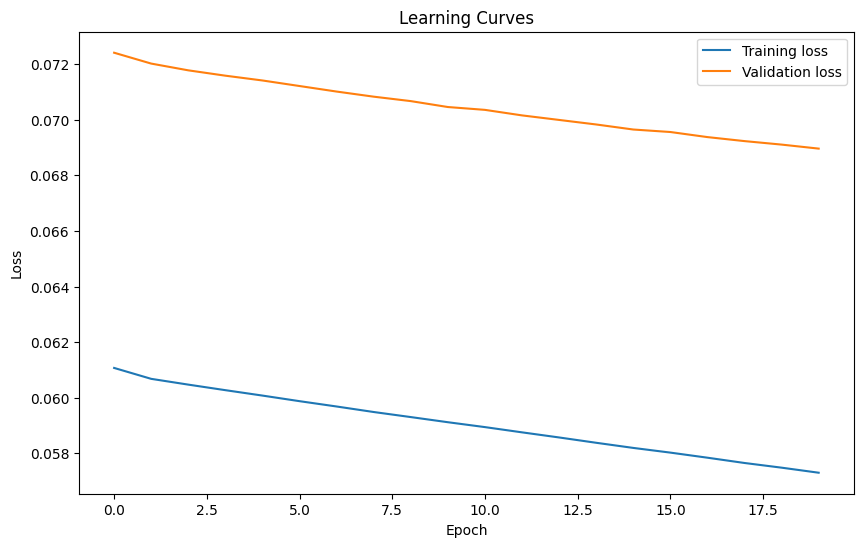

In [87]:
from torch.utils.data import TensorDataset, DataLoader

NUM_EPOCH = 20
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

criterion = nn.BCELoss()
optimizer = optim.Adam(mandelbrot_net.parameters(), lr=LEARNING_RATE)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Convert data to PyTorch tensors
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

# Create a TensorDataset and DataLoader
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


train_losses = []
val_losses = []

# Training loop
for epoch in range(NUM_EPOCH):
    mandelbrot_net.train() # Set the model to training mode
    train_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = mandelbrot_net(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)
    
    mandelbrot_net.eval() # Set the model to training mode
    val_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        
        for batch_X, batch_y in val_loader:
            outputs = mandelbrot_net(batch_X)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item() * batch_X.size(0)
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")


# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing Loop

In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convert data to Pytorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create a TensorDataset and DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Evaluation mode
mandelbrot_net.eval() 

with torch.no_grad():
    y_pred_tensor = mandelbrot_net(X_test_tensor)
    
    # Convert probabilities to binary predictions (0 or 1)
    y_pred = (y_pred_tensor > 0.5).float() 

    # Calculate metrics
    accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
    print(f"Test Accuracy: {accuracy:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test_tensor.numpy(), y_pred.numpy()))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()))

Test Accuracy: 0.9680

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       419
         1.0       0.88      0.93      0.90        81

    accuracy                           0.97       500
   macro avg       0.93      0.95      0.94       500
weighted avg       0.97      0.97      0.97       500

Confusion Matrix:
[[409  10]
 [  6  75]]
